### In this notebook we address state space models for a plasma experiment
The HITSI-U experiment relies on a set of four injectors, each with three circuit variables. The model for the circuit is the following state space model:
$$\dot{\mathbf x} = \mathbf A \mathbf x + \mathbf B \mathbf u,$$
$$\mathbf y = \mathbf C \mathbf x,$$
with the matrices defined below. In order to generate state space models that are
stable (even if there is substantial experimental noise), we need to constrain
the $\mathbf A$ matrix to be negative definite (note that if $\mathbf u = \mathbf K \mathbf x$ as in a Kalman filter, we only need the weaker condition that $\mathbf A + \mathbf{B}\mathbf K$ is negative definite). 

The optimization problem solved for provably stable linear models is described further in example7_reboot.ipynb in this same folder. 

In [1]:
# import libraries
import numpy as np
import pysindy as ps
from matplotlib import pyplot as plt
from scipy.signal import StateSpace, lsim, dlsim
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error

In [2]:
# Define the state space model 

Amplitude = 600
Amplitude1 = 600
Frequency = 19000  # injector frequency
RunTime = .004
SampleTime = 1e-7 
L1 = 8.0141e-7 #H
L2 = 2.0462e-6 #H
M = .161 * L2  # Coupling coefficient
Mw = .1346 * L2  # Coupling coefficient
Cap = 96e-6  # F
R1 = .0025  # Ohm
R2 = .005  # Ohm
R3 = .005  # Ohm
dT = 1e-7
NoisePower = 0.1
PhaseAngle1 = 90
PhaseAngle2 = 180
PhaseAngle3 = 270

# Scale factor in front of the entries to the A matrix 
# that are affected by mutual inductance
scalar1 = 1/((L2-Mw)*( (L2 ** 2) - (4*M ** 2)  +  2*L2*Mw +  (Mw ** 2) ))

x3a =  (-L2 ** 2)*R2 + (2*M ** 2)*R2-L2*Mw*R2
x3b = (-L2 ** 2) + (2*M ** 2)-L2*Mw
x3c = (L2 ** 2)*R2-(2*M ** 2)*R2 + L2*Mw*R2 + (L2 ** 2)*R3-(2*M ** 2)*R3 + L2*Mw*R3
x3d = L2*M*R2 - M*Mw*R2
x3e = L2*M-M*Mw
x3f = -L2*M*R2 + M*Mw*R2-L2*M*R3 + M*Mw*R3
x3g = L2*M*R2-M*Mw*R2
x3h = L2*M-M*Mw
x3i = -L2*M*R2 + M*Mw*R2-L2*M*R3 + M*Mw*R3
x3j = -2*(M ** 2)*R2 + L2*Mw*R2 + (Mw ** 2)*R2
x3k = -2*(M ** 2) + L2*Mw + Mw ** 2
x3l = 2*(M ** 2)*R2-L2*Mw*R2-(Mw ** 2)*R2 + 2*R3*(M ** 2)-L2*Mw*R3-R3*Mw ** 2

# Entries for x6 in A matrix
x6a = -L2*M*R2 + M*Mw*R2
x6b = -L2*M + M*Mw
x6c = L2*M*R2-M*Mw*R2 + L2*M*R3-M*Mw*R3
x6d = R2*(L2 ** 2)-2*R2*(M ** 2) + L2*Mw*R2
x6e = (L2 ** 2)-2*(M ** 2) + L2*Mw
x6f = -R2*(L2 ** 2) + 2*R2*(M ** 2)-L2*Mw*R2-R3*(L2 ** 2) + 2*R3*(M ** 2)-L2*Mw*R3
x6g = 2*R2*(M ** 2)-L2*Mw*R2-R2*(Mw ** 2)
x6h = 2*(M ** 2)-L2*Mw-(Mw ** 2)
x6i = -2*R2*(M ** 2) + L2*Mw*R2 + R2*(Mw ** 2)-2*R3*(M ** 2) + L2*Mw*R3 + R3*(Mw ** 2)
x6j = -L2*M*R2 + M*Mw*R2
x6k = -L2*M + M*Mw
x6l = L2*M*R2-M*Mw*R2 + L2*M*R3-M*Mw*R3
##Entries for x9 in A matrix
x9a = -L2*M*R2  +  M*Mw*R2
x9b = -L2* M  +  M* Mw
x9c = L2* M* R2 - M* Mw* R2 *  +  L2* M *R3  - M* Mw* R3
x9d = 2* (M ** 2) *R2 - L2*Mw* R2 - (Mw ** 2) *R2
x9e = 2 *(M ** 2) - L2* Mw - (Mw ** 2)
x9f = -2* (M ** 2)* R2 +  L2 *Mw *R2  +  (Mw ** 2) *R2 - 2* (M ** 2) *R3  +  L2 *Mw* R3  +  (Mw ** 2) *R3
x9g =(L2 ** 2) *R2 - 2* (M ** 2) *R2  +  L2 *Mw *R2
x9h = (L2 ** 2) - 2* (M ** 2)  +  L2 *Mw
x9i = -(L2 ** 2) *R2  +  2* (M ** 2)* R2 - L2 *Mw *R2 - (L2 ** 2) *R3  +  2* (M ** 2)* R3- L2 *Mw *R3
x9j = -L2 *M *R2  +  M*Mw*R2
x9k = -L2 *M  +  M *Mw 
x9l = L2*M*R2 - M* Mw *R2  +  L2 *M *R3 - M* Mw *R3

#Entries for x12 in A matrix
x12a = -2* (M ** 2) *R2 +  L2* Mw* R2  + (Mw ** 2)* R2
x12b = -2 *(M ** 2)  +  L2 *Mw  +  (Mw ** 2)
x12c = 2 *(M ** 2) *R2 - L2 *Mw *R2 - (Mw ** 2) *R2  +  2 *(M ** 2) *R3 - L2 *Mw *R3 - (Mw ** 2) *R3
x12d = L2 *M *R2 - M *Mw *R2
x12e = L2 *M - M *Mw
x12f = -L2 *M *R2  +  M *Mw *R2 - L2 *M *R3  +  M *Mw* R3
x12g = L2 *M *R2 - M *Mw *R2
x12h = L2 *M - M *Mw
x12i = -L2 *M *R2  +  M *Mw *R2 - L2 *M *R3  +  M *Mw *R3
x12j = (-L2 ** 2) *R2  +  2 *(M ** 2) *R2 - L2 *Mw *R2
x12k = (-L2 ** 2)  +  2 *(M ** 2) - L2* Mw
x12l = (L2 ** 2) *R2 - 2 *(M ** 2) *R2  +  L2 *Mw *R2  +  (L2 ** 2) *R3 - 2*(M ** 2)* R3  +  L2 *Mw *R3

A = np.array([[((-1/L1)*(R1 + R2)), -1/L1, R2*1/L1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [1/Cap, 0, -1/Cap, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [-scalar1*x3a, -scalar1*x3b,-scalar1*x3c, -scalar1*x3d, 
      -scalar1*x3e, -scalar1*x3f, -scalar1*x3g, -scalar1*x3h, 
      -scalar1*x3i, -scalar1*x3j, -scalar1*x3k, -scalar1*x3l],
     [0, 0, 0, ((-1/L1)*(R1 + R2)), -1/L1, R2*1/L1, 0, 0, 0, 0, 0, 0], 
     [0, 0, 0,  1/Cap, 0, -1/Cap, 0, 0, 0, 0, 0, 0], 
     [scalar1*x6a, scalar1*x6b, scalar1*x6c, scalar1*x6d, 
      scalar1*x6e, scalar1*x6f, scalar1*x6g, scalar1*x6h, 
      scalar1*x6i, scalar1*x6j, scalar1*x6k, scalar1*x6l],
     [0, 0, 0, 0, 0, 0, ((-1/L1)*(R1 + R2)), -1/L1, R2*1/L1, 0, 0, 0], 
     [0, 0, 0, 0, 0, 0, 1/Cap, 0, -1/Cap, 0, 0, 0], 
     [scalar1*x9a, scalar1*x9b, scalar1*x9c, scalar1*x9d, 
      scalar1*x9e, scalar1*x9f, scalar1*x9g, scalar1*x9h, 
      scalar1*x9i, scalar1*x9j, scalar1*x9k, scalar1*x9l], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, ((-1/L1)*(R1 + R2)), -1/L1, R2*1/L1], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1/Cap, 0, -1/Cap], 
     [-scalar1*x12a, -scalar1*x12b, -scalar1*x12c, -scalar1*x12d,
      -scalar1*x12e, -scalar1*x12f, -scalar1*x12g, -scalar1*x12h, 
      -scalar1*x12i, -scalar1*x12j, -scalar1*x12k, -scalar1*x12l]]
)

B = np.array([[1/L1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 1/L1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1/L1, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1/L1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]]
)

C = np.array([[0,0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
)

D = np.zeros((C.shape[0], C.shape[0]))
print(A.shape, C.shape, B.shape, D.shape)
print(np.linalg.eigvals(A)) # Notice all negative eigenvalues!

(12, 12) (4, 12) (12, 4) (4, 4)
[-5374.04778628+128310.86801552j -5374.04778628-128310.86801552j
 -6150.9991369 +138653.66264826j -6150.9991369 -138653.66264826j
 -6044.9626724 +137273.04651637j -6044.9626724 -137273.04651637j
 -6044.96265483+137273.04655165j -6044.96265483-137273.04655165j
 -2052.57854051     +0.j         -2915.80444687     +0.j
 -2915.80453607     +0.j         -2983.64806906     +0.j        ]


In [3]:
# continuous time system
sysc = StateSpace(A, B, C, D) 

# discrete time system
# sysd = sysc.to_discrete(dT)

### Load in the voltage control inputs
These are square waves at some pre-defined injector frequency.

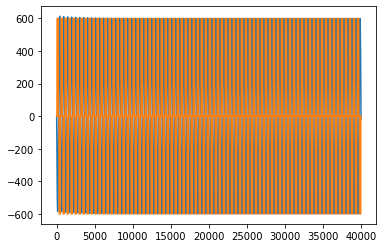

In [4]:
# Ad = sysd.A
# Bd = sysd.B
# Cd = sysd.C
# Dd = sysd.D

# G = np.eye(3)
# H = np.zeros((3, 3))

# Q = .001  # diag(.001*ones(1,size(A, 1))) % disturbance covariance
# R = np.diag(10 * np.ones(B.shape[1]))  # Noise covariance
time = np.linspace(0, RunTime, int(RunTime / SampleTime) + 1, endpoint=True)  #(0:SampleTime:RunTime)

data = loadmat('data/voltages.mat')
voltage1 = data['voltage']  # / 1000
voltage2 = data['newVoltageShift1']  # / 1000
voltage3 = data['newVoltageShift2']  # / 1000
voltage4 = data['newVoltageShift3']  # / 1000
plt.plot(voltage1)
plt.plot(voltage3)
plt.show()

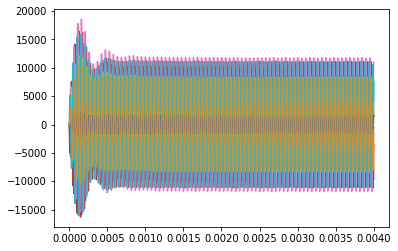

In [5]:
tout, yout, xout = lsim(
    sysc, 
    np.hstack([voltage1, voltage2, voltage3, voltage4]), 
    time
)

# Add some noise proportional to the signal with the smallest amplitude of the 12
rmse = mean_squared_error(xout[:, 1], np.zeros(xout[:, 1].shape), squared=False)
xout = xout + np.random.normal(0, rmse / 100.0 * 1, xout.shape) # 1% noise

# syskf = StateSpace(
#     Ad-L@Cd, 
#     np.hstack((Bd, L)), 
#     np.eye(12), 
#     0*np.hstack((Bd, L)), 
#     dt=dT
# )
# tkout, ykout, xkout = dlsim(
#     syskf, 
#     np.hstack([voltage, voltage, voltage, voltage, yout]), 
#     time
# )

# Could consider rescaling units here
# xout = xout
# yout = yout
# tout = tout 
# dt = tout[1] - tout[0]
for i in range(12):
    plt.plot(tout, xout[:, i])

In [12]:
# Okay time to use PySINDy on this 12D system of ODEs
u = np.hstack([voltage1, voltage2, voltage3, voltage4])
sindy_library = ps.PolynomialLibrary(degree=1, include_bias=False)

# Discover dx/dt = Ax + Bu 

### Try STLSQ instead -- you will likely get an unstable model!!!
# optimizer_stable = ps.STLSQ(threshold=1e2, verbose=True)

### Below: special optimizer if need to make sure linear matrix is stable! ###

optimizer_stable = ps.StableLinearSR3(
    threshold=0,
    thresholder='l1',
    nu=1e-5,
    max_iter=10,
    tol=1e-5,
    verbose=True,
)

model = ps.SINDy(feature_library=sindy_library, 
                 optimizer=optimizer_stable)
model.fit(xout, t=tout, u=u)
# model.print()

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stable_linear_sr3.py:199: UserWarning: This optimizer is set up to only be used with a purely linear library in the variables. No constant or nonlinear terms!
  "This optimizer is set up to only be used with a purely linear"


 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y - Xw|^2 + |w - u|^2 / v + R(u)


/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1338: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


         0 ... 3.2996e+25 ... 1.9200e+18 ... 0.0000e+00 ... 3.2996e+25
         1 ... 3.2607e+25 ... 1.7680e+18 ... 0.0000e+00 ... 3.2607e+25
         2 ... 3.2602e+25 ... 1.7677e+18 ... 0.0000e+00 ... 3.2602e+25
         3 ... 3.2602e+25 ... 1.7677e+18 ... 0.0000e+00 ... 3.2602e+25
         4 ... 3.2602e+25 ... 1.7677e+18 ... 0.0000e+00 ... 3.2602e+25
         5 ... 3.2602e+25 ... 1.7677e+18 ... 0.0000e+00 ... 3.2602e+25
         6 ... 3.2602e+25 ... 1.7677e+18 ... 0.0000e+00 ... 3.2602e+25
         7 ... 3.2602e+25 ... 1.7677e+18 ... 0.0000e+00 ... 3.2602e+25
         8 ... 3.2602e+25 ... 1.7677e+18 ... 0.0000e+00 ... 3.2602e+25
         9 ... 3.2602e+25 ... 1.7677e+18 ... 0.0000e+00 ... 3.2602e+25


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stable_linear_sr3.py:414: ConvergenceWarning: StableLinearSR3._reduce did not converge after 10 iterations.
  ConvergenceWarning,


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=1, include_bias=False),
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
                     'x10', 'x11', 'u0', 'u1', 'u2', 'u3'],
      optimizer=StableLinearSR3(max_iter=10, nu=1e-05, threshold=0,
                                verbose=True))

### Without noise, can match A and B matrices quite well

In [13]:
Xi = model.coefficients()
r = Xi.shape[0]
B_SINDy = Xi[:r, r:]
A_SINDy = Xi[:r, :r]
print(B_SINDy, B)
print(A_SINDy, A)

[[ 1.25402879e+06 -4.07931024e+02  8.39266946e+02 -4.15414375e+02]
 [-1.26046389e+02 -7.71156619e+00  9.06189166e+00 -3.05748525e+01]
 [-1.61346499e+03  1.78309591e+02 -3.42198300e+02  1.83170102e+02]
 [ 5.86865693e+04  9.75812812e+05 -6.69119036e+02 -2.32464144e+05]
 [ 2.14588017e+03  8.27033159e+01 -1.08307988e+01  1.01053283e+02]
 [ 2.71428582e+03 -1.13119911e+02  2.23333567e+02 -1.20192090e+02]
 [-1.21539141e+05 -8.17010282e+02  1.19414524e+06 -6.59894724e+02]
 [ 2.69205704e+02  1.10875358e+00  2.44746128e+00 -2.49279325e+01]
 [-7.74996578e+03  1.59514999e+02 -3.58996988e+02  1.48226453e+02]
 [-2.41900603e+04 -2.33603857e+05 -2.30417022e+02  9.74298852e+05]
 [ 1.65497575e+03 -1.10769739e+01 -6.56993002e+00  6.47176206e+00]
 [-6.83650118e+02 -1.80714897e+02  2.29775880e+02 -1.73026126e+02]] [[1247800.75117605       0.               0.               0.        ]
 [      0.               0.               0.               0.        ]
 [      0.               0.               0.         

In [14]:
# Condition number is quite good actually!
np.linalg.cond(optimizer_stable.Theta_)

4287.445263701633

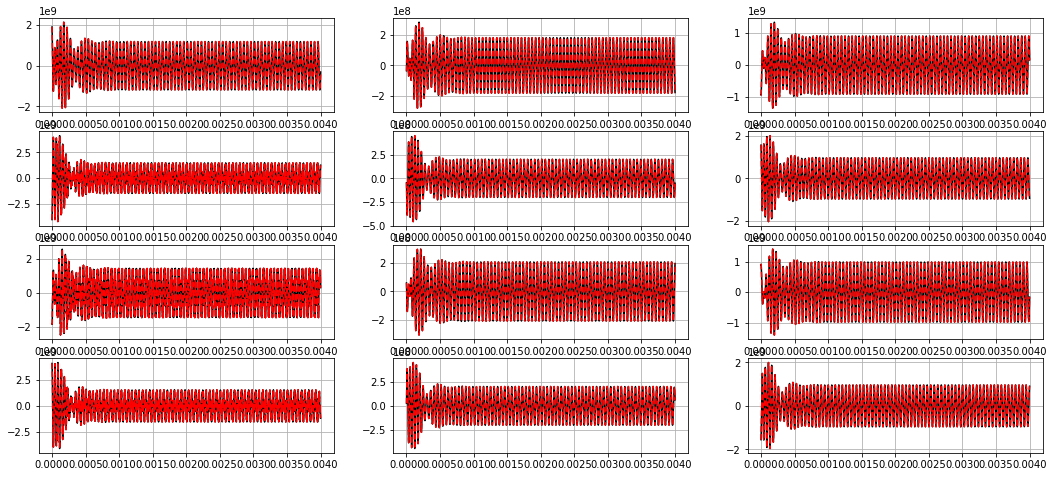

In [15]:
ydot_true = model.differentiate(xout, t=tout)
ydot_pred = model.predict(xout, u=u)
plt.figure(figsize=(18, 8))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.grid(True)
    plt.plot(tout, ydot_true[:, i], 'k')
    plt.plot(tout, ydot_pred[:, i], 'r--')

### Check if the A matrix is negative definite!
If not all the eigenvalues are negative, model is unstable. If so, optimize with the StableLinearOptimizer until the eigenvalues are pushed to be all negative. 

In [16]:
# print(np.sort(np.linalg.eigvals(optimizer_stable.coef_history[-1, :12, :12])))
# print(np.sort(np.linalg.eigvals(optimizer_stable.coef_history[0, :12, :12])))
Xi = model.coefficients()
print(np.sort(np.linalg.eigvals(Xi[:12, :12])))

[-6543.13785327-138469.93103945j -6543.13785327+138469.93103945j
 -5026.64681393-147468.07981402j -5026.64681393+147468.07981402j
 -4817.69723306-136887.863901j   -4817.69723306+136887.863901j
 -4019.81389282  -7150.14056386j -4019.81389282  +7150.14056386j
 -2913.67907567-126201.41988287j -2913.67907567+126201.41988287j
 -2718.31499163   -193.9220111j  -2718.31499163   +193.9220111j ]


### Now try resimulating the training data from some new initial condition
This is a 12D system and the time base is VERY well-sampled so integration might take a while!

In [17]:
x0_new = (np.random.rand(12) - 0.5) * 10000 
tout, yout, xout = lsim(
    sysc, 
    np.hstack([voltage1, voltage2, voltage3, voltage4]), 
    time,
    X0=x0_new,
)
x_pred = model.simulate(x0_new, 
                        t=tout[:int(len(tout) // 2):4], 
                        u=u[:int(len(tout) // 2):4, :])

/Users/alankaptanoglu/pysindy/pysindy/pysindy.py:873: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  "Last time point dropped in simulation because "


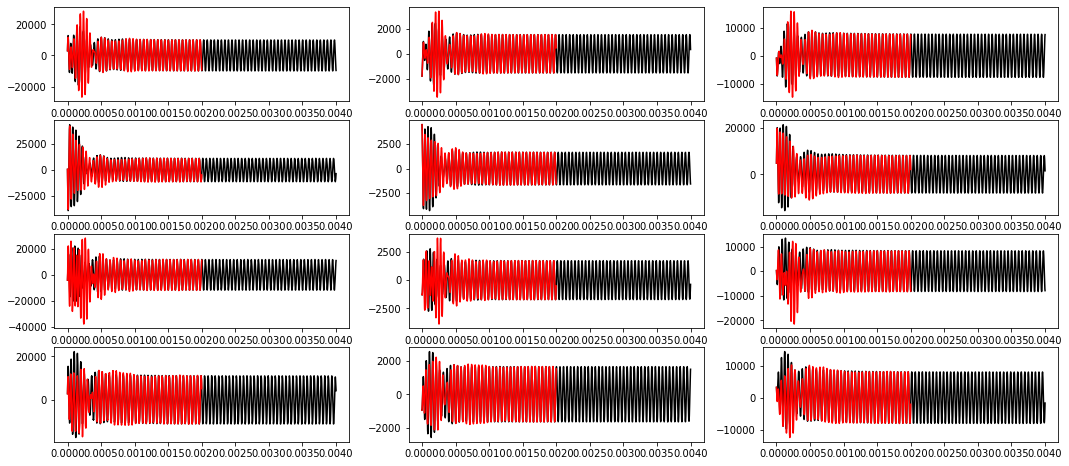

In [18]:
plt.figure(figsize=(18, 8))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.plot(time, xout[:, i], 'k')
    plt.plot(tout[:int(len(tout) // 2)-4:4], x_pred[:, i], 'r')